# Model sources with multi-resolution observations

This tutorial shows how to model sources frome images observed with different telescopes. We will use a multiband observation with the Hyper-Sprime Cam (HSC) and a single high-resolution image from the Hubble Space Telescope (HST).

In [1]:
# Import Packages and setup
import numpy as np
import astropy.io.fits as fits
from astropy.wcs import WCS

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

import scarlet2
from scarlet2 import plot
from astropy.visualization.lupton_rgb import AsinhMapping

import jax
import jax.numpy as jnp

## Load Data

We first load the HSC and HST images, channel names, and PSFs. For the images, we need to swap the byte order if necessary because a bug in astropy does not respect the local endianness… We also don’t have precomputed weight/variance maps, so we will need to compute them afterwards.

In [2]:
# Installing data package if not already installed
from scarlet2.utils import import_scarlet_test_data
import_scarlet_test_data()
from scarlet_test_data import data_path
import os

# Load the HSC image data
obs_hdu = fits.open(os.path.join(data_path, "test_resampling", "Cut_HSC1.fits"))
data_hsc = obs_hdu[0].data.astype('float32')
wcs_hsc = WCS(obs_hdu[0].header)
channels_hsc = ['g','r','i','z','y']

# Load the HSC PSF data
psf_hsc_data  = fits.open(os.path.join(data_path, "test_resampling", "PSF_HSC.fits"))[0].data.astype('float32')
psf_hsc = scarlet2.ArrayPSF(psf_hsc_data)

# Load the HST image data
hst_hdu = fits.open(os.path.join(data_path, "test_resampling", "Cut_HST1.fits"))
data_hst = hst_hdu[0].data.astype('float32')
wcs_hst = WCS(hst_hdu[0].header)
channels_hst = ['F814W']

# Load the HST PSF data
psf_hst = fits.open(os.path.join(data_path, "test_resampling", "PSF_HST.fits"))[0].data.astype('float32')
psf_hst = psf_hst[None,:,:]
psf_hst = scarlet2.ArrayPSF(psf_hst)

# Scale the HST data
data_hst = data_hst[None, ...].astype('float32')
data_hst *= data_hsc.max() / data_hst.max()

Next we have to create a source catalog for the images. We’ll use `sep` for that, but any other detection method will do. Since HST is higher resolution and less affected by blending, we use it for detection but we also run detection on the HSC image to calculate the background RMS:

In [3]:
import sep
from scarlet2 import Starlet

def makeCatalog(data_lr, data_hr, lvl = 3, wave = True):
    # Create a catalog of detected source by running SEP on the wavelet transform
    # of the sum of the high resolution images and the low resolution images interpolated 
    # to the high resolution grid
    
    coords_in = jnp.stack(jnp.meshgrid(jnp.linspace(0,1, data_lr.shape[-1]+2)[1:-1],
                                jnp.linspace(0,1, data_lr.shape[-2]+2)[1:-1]), -1)

    coords_out = jnp.stack(jnp.meshgrid(jnp.linspace(0,1, data_hr.shape[-2]+2)[1:-1],
                                        jnp.linspace(0,1, data_hr.shape[-2]+2)[1:-1]), -1)

    interp_im = jax.vmap(scarlet2.interpolation.resample2d, 
                      in_axes=(0,None,None))(data_lr, coords_in, coords_out)

    # Normalisation
    interp_im = interp_im/jnp.sum(interp_im, axis = (1,2))[:,None, None]
    hr_images = data_hr/jnp.sum(data_hr, axis = (1,2))[:,None, None]

    # Summation to create a detection image
    detect_image = jnp.sum(interp_im, axis = 0) + jnp.sum(hr_images, axis = 0)
    # Rescaling to HR image flux
    detect_image *= jnp.sum(data_hr)
    # Wavelet transform
    wave_detect = Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

    # Runs SEP detection
    bkg = sep.Background(np.array(detect))
    catalog = sep.extract(np.array(detect), 3, err=bkg.globalrms)
    bg_rms = []
    for img in [np.array(data_lr), np.array(data_hr)]:
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)

    return catalog, bg_rms, detect_image

In [4]:
# Making catalog.
# With the wavelet option on, only the first 3 wavelet levels are used for detection. Set to 1 for better detection
wave = 1
lvl = 3
catalog_hst, (bg_hsc, bg_hst), detect = makeCatalog(data_hsc, data_hst, lvl, wave)

# we can now set the empirical noise rms for both observations
obs_hst_weights = np.ones(data_hst.shape) / (bg_hst**2)[:, None, None]
obs_hsc_weights = np.ones(data_hsc.shape) / (bg_hsc**2)[:, None, None]

## Create Frame and Observations

We have two different instruments with different pixel resolutions, so we need two different observations. Since the HST image is at a much higher resolution, we define our model `Frame` to use the HST PSF and the HST resolution. The high resolution and low resolution `Observation` are then matched to the model frame, to define the renderering operation. 

In [5]:
obs_hst = scarlet2.Observation(data_hst,
                               wcs=wcs_hst,
                               psf=psf_hst,
                               channels=channels_hst,
                               weights=obs_hst_weights)

obs_hsc = scarlet2.Observation(data_hsc,
                               wcs=wcs_hsc,
                               psf=psf_hsc,
                               channels=channels_hsc,
                               weights=obs_hsc_weights)

Define the model frame using the high resolution image WCS

In [6]:
model_psf = scarlet2.psf.GaussianPSF(sigma=0.6)

model_frame = scarlet2.frame.Frame(
    bbox = scarlet2.Box((6,obs_hst.frame.bbox.shape[-2],obs_hst.frame.bbox.shape[-1])),
    psf = model_psf,
    wcs = obs_hst.frame.wcs,
    channels = obs_hst.frame.channels + obs_hsc.frame.channels
)

Match the observations to model frame

In [7]:
obs_hst.match(model_frame);
obs_hsc.match(model_frame);

Finally we can visualize the detections for the multi-band HSC and single-band HST images in their native resolutions:

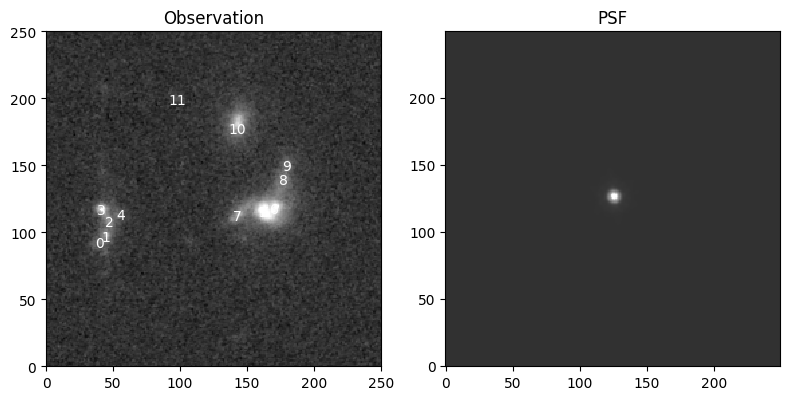

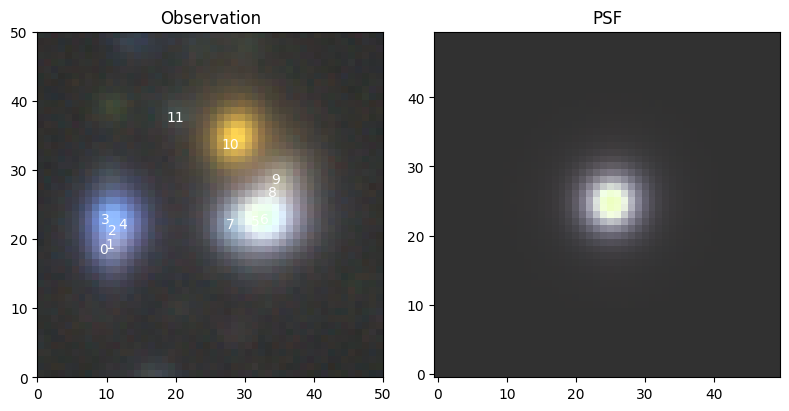

In [8]:
norm_hst = AsinhMapping(minimum=-1, stretch=5, Q=3)
norm_hsc = AsinhMapping(minimum=-1, stretch=5, Q=3)

pixel_hst = np.stack((catalog_hst['y'], catalog_hst['x']), axis=1)
# Convert the HST pixel coordinates to sky coordinates
ra_dec = obs_hst.frame.get_sky_coord(pixel_hst)
# Convert to HSC pixel
pixel_hsc = obs_hsc.frame.get_pixel(ra_dec)

plot.observation(obs_hst, norm=norm_hst, sky_coords=pixel_hst, show_psf=True);
plot.observation(obs_hsc, norm=norm_hsc, sky_coords=pixel_hsc, show_psf=True);

## Initialize sources from multiple observations

In [9]:
from scarlet2.scene import Scene
from scarlet2 import init
from scarlet2.source import Source
from scarlet2.spectrum import ArraySpectrum
from scarlet2.morphology import ArrayMorphology
from scarlet2.module import Parameter

from numpyro.distributions import constraints

In [10]:
with Scene(model_frame) as scene:
    for i, center in enumerate(ra_dec):
        try:
            spectrum, morph = init.from_gaussian_moments([obs_hst, obs_hsc], center, min_corr=0.99)
        except ValueError:
            spectrum = init.pixel_spectrum([obs_hst, obs_hsc], center)
            morph = init.compact_morphology()
        Source(
            center,
            spectrum,
            morph
            )

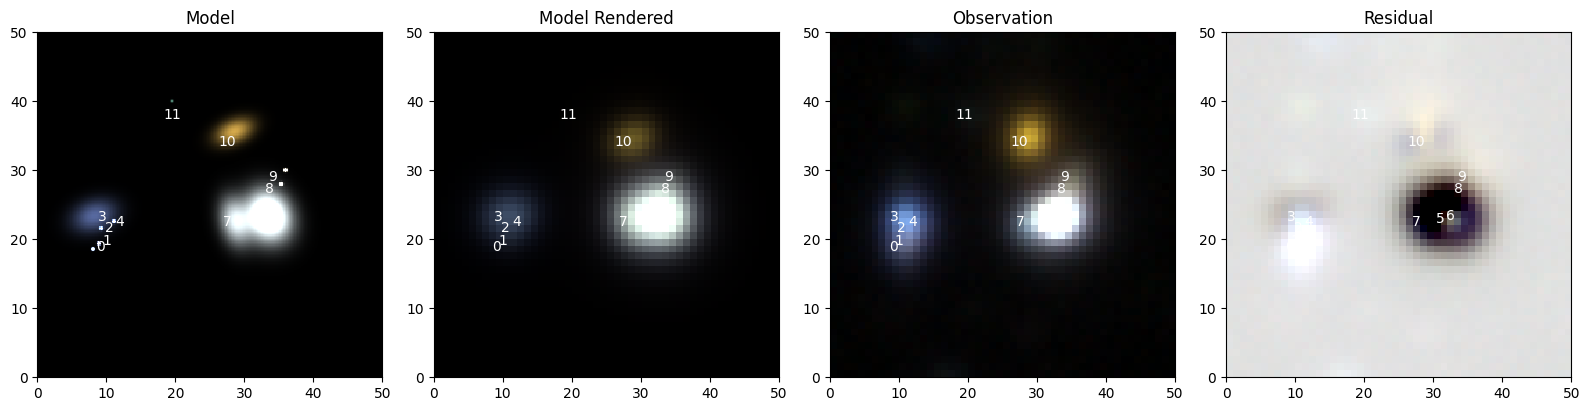

In [11]:
scarlet2.plot.scene(scene, observation=obs_hsc, show_rendered=True, show_observed=True, show_residual=True);

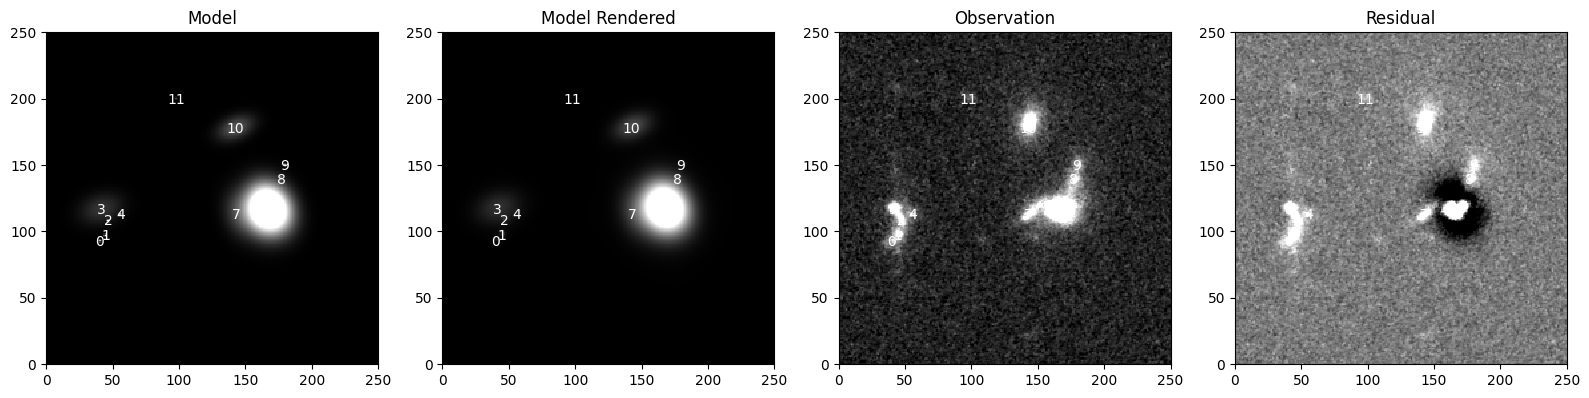

In [12]:
scarlet2.plot.scene(scene, observation=obs_hst, show_rendered=True, show_observed=True, show_residual=True);

Initialize sources parameters with their constraints

In [13]:
from functools import partial
from scarlet2.module import relative_step
spec_step = partial(relative_step, factor=0.05)

parameters = scene.make_parameters()
for i in range(len(scene.sources)):
    parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=spec_step)
    parameters += Parameter(scene.sources[i].morphology.data, name=f"morph.{i}", constraint=constraints.positive, stepsize=0.1)

scene.set_spectra_to_match([obs_hst, obs_hsc], parameters)

## Fit with multiple observations

In [14]:
scene_ = scene.fit([obs_hst, obs_hsc], parameters, max_iter=200)

100%|████| 200/200 [01:58<00:00,  1.68it/s, loss=101843.48, max_change=0.024008]


Show scene in HSC frame

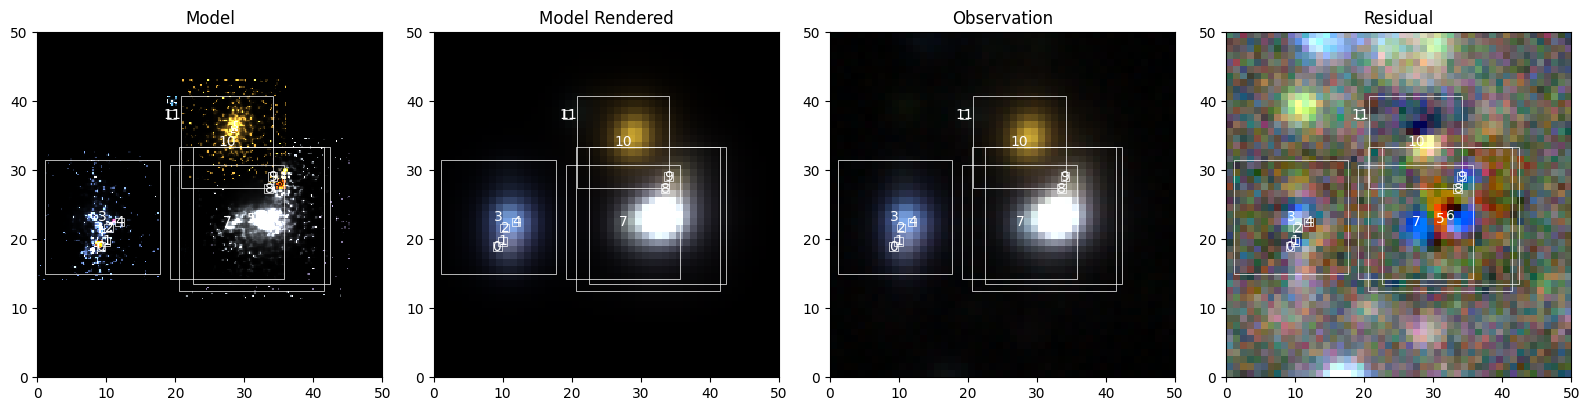

In [15]:
scarlet2.plot.scene(scene_, observation=obs_hsc, show_rendered=True, show_observed=True, show_residual=True, add_boxes=True);

Show scene in HST frame

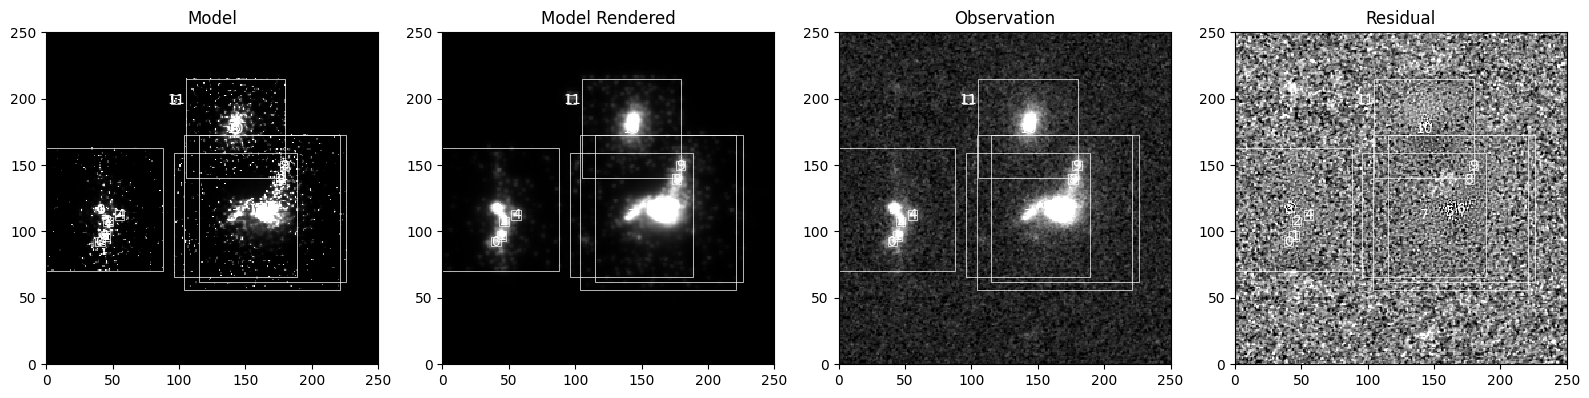

In [16]:
scarlet2.plot.scene(scene_, observation=obs_hst, show_rendered=True, show_observed=True, show_residual=True, add_boxes=True);